<a href="https://colab.research.google.com/github/aminoscape/alphafold2-cmaps/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AlphaFold2 w/ MMseqs2
Easy to use version of AlphaFold 2 [(Jumper et al. 2021, Nature)](https://www.nature.com/articles/s41586-021-03819-2) a protein structure prediction pipeline, with an API hosted at the Södinglab based on the MMseqs2 server [(Mirdita et al. 2019, Bioinformatics)](https://academic.oup.com/bioinformatics/article/35/16/2856/5280135) for the multiple sequence alignment creation. 

**WARNING**: this notebook does NOT use the AlphaFold2 pipeline for MSA/template generation. It may give better or worse results depending on number of sequences that can be found. Check out the [full AlphaFold2 pipeline](https://github.com/deepmind/alphafold) or Deepmind's official [google-colab notebook](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb).

<strong>For detailed instructions, see <a href="#Instructions">bottom</a> of notebook!</strong>

In [1]:
#@title Input protein sequence, then hit `Runtime` -> `Run all`
from google.colab import files
import os
import os.path
import re
import hashlib

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
# remove whitespaces
query_sequence = "".join(query_sequence.split())
query_sequence = re.sub(r'[^a-zA-Z]','', query_sequence).upper()

jobname = 'test' #@param {type:"string"}
# remove whitespaces
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)
jobname = add_hash(jobname, query_sequence)


with open(f"{jobname}.fasta", "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

# number of models to use
#@markdown ---
#@markdown ### Advanced settings
msa_mode = "MMseqs2 (UniRef+Environmental)" #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
num_models = 5 #@param [1,2,3,4,5] {type:"raw"}
use_msa = True if msa_mode.startswith("MMseqs2") else False
use_env = True if msa_mode == "MMseqs2 (UniRef+Environmental)" else False
use_custom_msa = True if msa_mode == "custom" else False
use_amber = False #@param {type:"boolean"}
use_templates = False #@param {type:"boolean"}
#@markdown ---
#@markdown ### Experimental options
homooligomer = 1 #@param [1,2,3,4,5,6,7,8] {type:"raw"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown ---
#@markdown Don't forget to hit `Runtime` -> `Run all` after updating form


if homooligomer > 1:
  if use_amber:
    print("amber disabled: amber is not currently supported for homooligomers")
    use_amber = False
  if use_templates:
    print("templates disabled: templates are not currently supported for homooligomers")
    use_templates = False

with open(f"{jobname}.log", "w") as text_file:
    text_file.write("num_models=%s\n" % num_models)
    text_file.write("use_amber=%s\n" % use_amber)
    text_file.write("use_msa=%s\n" % use_msa)
    text_file.write("msa_mode=%s\n" % msa_mode)
    text_file.write("use_templates=%s\n" % use_templates)
    text_file.write("homooligomer=%s\n" % homooligomer)

# decide which a3m to use
if use_msa:
  a3m_file = f"{jobname}.a3m"
elif use_custom_msa:
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1 
      if line.startswith("#"):
        continue
      if line.rstrip() == False:
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip() 
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

if save_to_google_drive == True:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

In [2]:
#@title Install dependencies
%%bash -s $use_amber $use_msa $use_templates

USE_AMBER=$1
USE_MSA=$2
USE_TEMPLATES=$3

if [ ! -f AF2_READY ]; then
  # install dependencies
  pip -q install biopython
  pip -q install dm-haiku
  pip -q install ml-collections
  pip -q install py3Dmol

  # download model
  if [ ! -d "alphafold/" ]; then
    git clone https://github.com/deepmind/alphafold.git --quiet
    (cd alphafold; git checkout 0bab1bf84d9d887aba5cfb6d09af1e8c3ecbc408 --quiet)
    mv alphafold alphafold_
    mv alphafold_/alphafold .
    # remove "END" from PDBs, otherwise biopython complains
    sed -i "s/pdb_lines.append('END')//" /content/alphafold/common/protein.py
    sed -i "s/pdb_lines.append('ENDMDL')//" /content/alphafold/common/protein.py
  fi

  # download model params (~1 min)
  if [ ! -d "params/" ]; then
    wget -qnc https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar
    mkdir params
    tar -xf alphafold_params_2021-07-14.tar -C params/
    rm alphafold_params_2021-07-14.tar
  fi
  touch AF2_READY
fi
# download libraries for interfacing with MMseqs2 API
if [ ${USE_MSA} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f MMSEQ2_READY ]; then
    apt-get -qq -y update 2>&1 1>/dev/null
    apt-get -qq -y install jq curl zlib1g gawk 2>&1 1>/dev/null
    touch MMSEQ2_READY
  fi
fi
# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign3=3.2.2 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  (cd /usr/local/lib/python3.7/site-packages; patch -s -p0 < /content/alphafold_/docker/openmm.patch)
  wget -qnc https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
  mv stereo_chemical_props.txt alphafold/common/
  touch AMBER_READY
fi

In [3]:
#@title Import libraries
# setup the model
if "model" not in dir():

  # hiding warning messages
  import warnings
  from absl import logging
  import os
  import tensorflow as tf
  warnings.filterwarnings('ignore')
  logging.set_verbosity("error")
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  tf.get_logger().setLevel('ERROR')

  import sys
  import numpy as np
  import pickle
  from alphafold.common import protein
  from alphafold.data import pipeline
  from alphafold.data import templates
  from alphafold.model import data
  from alphafold.model import config
  from alphafold.model import model
  from alphafold.data.tools import hhsearch

  # plotting libraries
  import py3Dmol
  import matplotlib.pyplot as plt
  import ipywidgets
  from ipywidgets import interact, fixed, GridspecLayout, Output


if use_amber and "relax" not in dir():
  sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')
  from alphafold.relax import relax

def mk_mock_template(query_sequence):
  # since alphafold's model requires a template input
  # we create a blank example w/ zero input, confidence -1
  ln = len(query_sequence)
  output_templates_sequence = "-"*ln
  output_confidence_scores = np.full(ln,-1)
  templates_all_atom_positions = np.zeros((ln, templates.residue_constants.atom_type_num, 3))
  templates_all_atom_masks = np.zeros((ln, templates.residue_constants.atom_type_num))
  templates_aatype = templates.residue_constants.sequence_to_onehot(output_templates_sequence,
                                                                    templates.residue_constants.HHBLITS_AA_TO_ID)
  template_features = {'template_all_atom_positions': templates_all_atom_positions[None],
                       'template_all_atom_masks': templates_all_atom_masks[None],
                       'template_sequence': [f'none'.encode()],
                       'template_aatype': np.array(templates_aatype)[None],
                       'template_confidence_scores': output_confidence_scores[None],
                       'template_domain_names': [f'none'.encode()],
                       'template_release_date': [f'none'.encode()]}
  return template_features

def mk_template(jobname):
  template_featurizer = templates.TemplateHitFeaturizer(
      mmcif_dir="templates/",
      max_template_date="2100-01-01",
      max_hits=20,
      kalign_binary_path="kalign",
      release_dates_path=None,
      obsolete_pdbs_path=None)

  hhsearch_pdb70_runner = hhsearch.HHSearch(binary_path="hhsearch",databases=[jobname])

  a3m_lines = "\n".join(open(f"{jobname}.a3m","r").readlines())
  hhsearch_result = hhsearch_pdb70_runner.query(a3m_lines)
  hhsearch_hits = pipeline.parsers.parse_hhr(hhsearch_result)
  templates_result = template_featurizer.get_templates(query_sequence=query_sequence,
                                                       query_pdb_code=None,
                                                       query_release_date=None,
                                                       hits=hhsearch_hits)
  return templates_result.features

def set_bfactor(pdb_filename, bfac, idx_res, chains):
  I = open(pdb_filename,"r").readlines()
  O = open(pdb_filename,"w")
  for line in I:
    if line[0:6] == "ATOM  ":
      seq_id = int(line[22:26].strip()) - 1
      seq_id = np.where(idx_res == seq_id)[0][0]
      O.write(f"{line[:21]}{chains[seq_id]}{line[22:60]}{bfac[seq_id]:6.2f}{line[66:]}")
  O.close()

def predict_structure(prefix, feature_dict, Ls, model_params, use_model, do_relax=False, random_seed=0):  
  """Predicts structure using AlphaFold for the given sequence."""

  # Minkyung's code
  # add big enough number to residue index to indicate chain breaks
  idx_res = feature_dict['residue_index']
  L_prev = 0
  # Ls: number of residues in each chain
  for L_i in Ls[:-1]:
      idx_res[L_prev+L_i:] += 200
      L_prev += L_i  
  chains = list("".join([ascii_uppercase[n]*L for n,L in enumerate(Ls)]))
  feature_dict['residue_index'] = idx_res

  # Run the models.
  plddts,paes = [],[]
  unrelaxed_pdb_lines = []
  relaxed_pdb_lines = []

  for model_name, params in model_params.items():
    if model_name in use_model:
      print(f"running {model_name}")
      # swap params to avoid recompiling
      # note: models 1,2 have diff number of params compared to models 3,4,5
      if any(str(m) in model_name for m in [1,2]): model_runner = model_runner_1
      if any(str(m) in model_name for m in [3,4,5]): model_runner = model_runner_3
      model_runner.params = params
      
      processed_feature_dict = model_runner.process_features(feature_dict, random_seed=random_seed)
      prediction_result = model_runner.predict(processed_feature_dict)
      unrelaxed_protein = protein.from_prediction(processed_feature_dict,prediction_result)
      unrelaxed_pdb_lines.append(protein.to_pdb(unrelaxed_protein))
      plddts.append(prediction_result['plddt'])
      paes.append(prediction_result['predicted_aligned_error'])

      if do_relax:
        # Relax the prediction.
        amber_relaxer = relax.AmberRelaxation(max_iterations=0,tolerance=2.39,
                                              stiffness=10.0,exclude_residues=[],
                                              max_outer_iterations=20)      
        relaxed_pdb_str, _, _ = amber_relaxer.process(prot=unrelaxed_protein)
        relaxed_pdb_lines.append(relaxed_pdb_str)

  # rerank models based on predicted lddt
  lddt_rank = np.mean(plddts,-1).argsort()[::-1]
  out = {}
  print("reranking models based on avg. predicted lDDT")
  for n,r in enumerate(lddt_rank):
    print(f"model_{n+1} {np.mean(plddts[r])}")

    unrelaxed_pdb_path = f'{prefix}_unrelaxed_model_{n+1}.pdb'    
    with open(unrelaxed_pdb_path, 'w') as f: f.write(unrelaxed_pdb_lines[r])
    set_bfactor(unrelaxed_pdb_path, plddts[r], idx_res, chains)

    if do_relax:
      relaxed_pdb_path = f'{prefix}_relaxed_model_{n+1}.pdb'
      with open(relaxed_pdb_path, 'w') as f: f.write(relaxed_pdb_lines[r])
      set_bfactor(relaxed_pdb_path, plddts[r], idx_res, chains)

    out[f"model_{n+1}"] = {"plddt":plddts[r], "pae":paes[r]}
  return out

In [4]:
#@title Call MMseqs2 to get MSA/templates
%%bash -s $use_amber $use_msa $use_templates $jobname $use_env
USE_AMBER=$1
USE_MSA=$2
USE_TEMPLATES=$3
NAME=$4
USE_ENV=$5
if [ ${USE_MSA} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f ${NAME}.mmseqs2.tar.gz ]; then
    # query MMseqs2 webserver
    echo "submitting job"
    MODE=all
    if [ ${USE_ENV} == "True" ]; then
      MODE=env
    fi
    ID=$(curl -s -F q=@${NAME}.fasta -F mode=${MODE} https://a3m.mmseqs.com/ticket/msa | jq -r '.id')
    STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
    while [ "${STATUS}" == "RUNNING" ] || [ "${STATUS}" == "PENDING" ]; do
      STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
      sleep 1
    done
    if [ "${STATUS}" == "COMPLETE" ]; then
      curl -s https://a3m.mmseqs.com/result/download/${ID} > ${NAME}.mmseqs2.tar.gz
      tar xzf ${NAME}.mmseqs2.tar.gz
      if [ ${USE_ENV} == "True" ]; then
        cat uniref.a3m bfd.mgnify30.metaeuk30.smag30.a3m > tmp.a3m
        tr -d '\000' < tmp.a3m > ${NAME}.a3m
        rm uniref.a3m bfd.mgnify30.metaeuk30.smag30.a3m tmp.a3m
      else
        tr -d '\000' < uniref.a3m > ${NAME}.a3m
        rm uniref.a3m
      fi
      mv pdb70.m8 ${NAME}.m8
    else
      echo "MMseqs2 server did not return a valid result."
      cp ${NAME}.fasta ${NAME}.a3m
    fi
  fi
  if [ ${USE_MSA} == "True" ]; then
    echo "Found $(grep -c ">" ${NAME}.a3m) sequences (after redundacy filtering)"
  fi
  if [ ${USE_TEMPLATES} == "True" ] && [ ! -f ${NAME}_hhm.ffindex ]; then
    echo "getting templates"
    if [ -s ${NAME}.m8 ]; then
      if [ ! -d templates ]; then
        mkdir templates/
      fi
      printf "pdb\tevalue\n"
      head -n 20 ${NAME}.m8 | awk '{print $2"\t"$11}'
      TMPL=$(head -n 20 ${NAME}.m8 | awk '{printf $2","}')
      curl -s https://a3m-templates.mmseqs.com/template/${TMPL} | tar xzf - -C templates/
      mv templates/pdb70_a3m.ffdata ${NAME}_a3m.ffdata
      mv templates/pdb70_a3m.ffindex ${NAME}_a3m.ffindex
      mv templates/pdb70_hhm.ffdata ${NAME}_hhm.ffdata
      mv templates/pdb70_hhm.ffindex ${NAME}_hhm.ffindex
      cp ${NAME}_a3m.ffindex ${NAME}_cs219.ffindex
      touch ${NAME}_cs219.ffdata
    else
      echo "no templates found"
    fi
  fi
fi

submitting job
Found 1935 sequences (after redundacy filtering)


In [5]:
#@title Gather input features, predict structure
from string import ascii_uppercase

# collect model weights
use_model = {}
if "model_params" not in dir(): model_params = {}
for model_name in ["model_1","model_2","model_3","model_4","model_5"][:num_models]:
  use_model[model_name] = True
  if model_name not in model_params:
    model_params[model_name] = data.get_model_haiku_params(model_name=model_name+"_ptm", data_dir=".")
    if model_name == "model_1":
      model_config = config.model_config(model_name+"_ptm")
      model_config.data.eval.num_ensemble = 1
      model_runner_1 = model.RunModel(model_config, model_params[model_name])
    if model_name == "model_3":
      model_config = config.model_config(model_name+"_ptm")
      model_config.data.eval.num_ensemble = 1
      model_runner_3 = model.RunModel(model_config, model_params[model_name])

# parse TEMPLATES
if use_templates and os.path.isfile(f"{jobname}_hhm.ffindex"):
  template_features = mk_template(jobname)
else:
  template_features = mk_mock_template(query_sequence * homooligomer)

# parse MSA
a3m_lines = "".join(open(a3m_file,"r").readlines())
msa, deletion_matrix = pipeline.parsers.parse_a3m(a3m_lines)

if homooligomer == 1:
  msas = [msa]
  deletion_matrices = [deletion_matrix]
else:
  # make multiple copies of msa for each copy
  # AAA------
  # ---AAA---
  # ------AAA
  #
  # note: if you concat the sequences (as below), it does NOT work
  # AAAAAAAAA
  msas = []
  deletion_matrices = []
  Ln = len(query_sequence)
  for o in range(homooligomer):
    L = Ln * o
    R = Ln * (homooligomer-(o+1))
    msas.append(["-"*L+seq+"-"*R for seq in msa])
    deletion_matrices.append([[0]*L+mtx+[0]*R for mtx in deletion_matrix])

# gather features
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence*homooligomer,
                                      description="none",
                                      num_res=len(query_sequence)*homooligomer),
    **pipeline.make_msa_features(msas=msas,deletion_matrices=deletion_matrices),
    **template_features
}
outs = predict_structure(jobname, feature_dict,
                         Ls=[len(query_sequence)]*homooligomer,
                         model_params=model_params, use_model=use_model,
                         do_relax=use_amber)

running model_1
running model_2
running model_3
running model_4
running model_5
reranking models based on avg. predicted lDDT
model_1 97.51782115465463
model_2 97.10846877913468
model_3 96.47046414303716
model_4 96.30405478689137
model_5 95.81889196486807


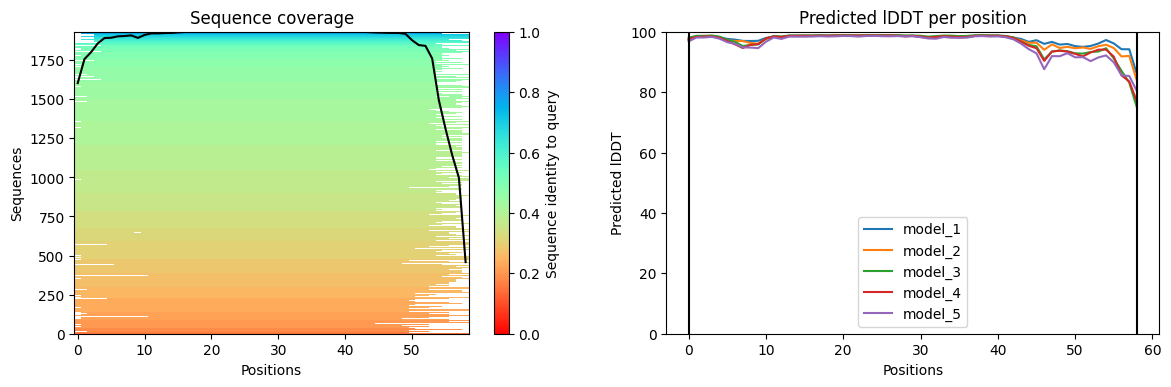

Predicted Alignment Error


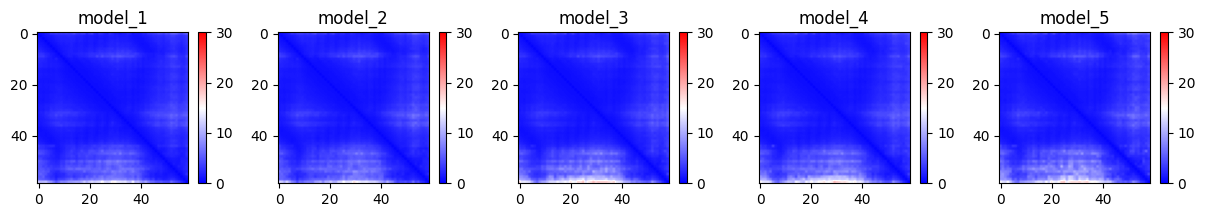

In [6]:
#@title Make plots

# gather MSA info
deduped_full_msa = list(dict.fromkeys(msa))
msa_arr = np.array([list(seq) for seq in deduped_full_msa])
seqid = (np.array(list(query_sequence)) == msa_arr).mean(-1)
seqid_sort = seqid.argsort() #[::-1]
non_gaps = (msa_arr != "-").astype(float)
non_gaps[non_gaps == 0] = np.nan

##################################################################
plt.figure(figsize=(14,4),dpi=100)
##################################################################
plt.subplot(1,2,1); plt.title("Sequence coverage")
plt.imshow(non_gaps[seqid_sort]*seqid[seqid_sort,None],
           interpolation='nearest', aspect='auto',
           cmap="rainbow_r", vmin=0, vmax=1, origin='lower')
plt.plot((msa_arr != "-").sum(0), color='black')
plt.xlim(-0.5,msa_arr.shape[1]-0.5)
plt.ylim(-0.5,msa_arr.shape[0]-0.5)
plt.colorbar(label="Sequence identity to query",)
plt.xlabel("Positions")
plt.ylabel("Sequences")

##################################################################
plt.subplot(1,2,2); plt.title("Predicted lDDT per position")
for model_name,value in outs.items():
  plt.plot(value["plddt"],label=model_name)
if homooligomer > 0:
  for n in range(homooligomer+1):
    x = n*(len(query_sequence)-1)
    plt.plot([x,x],[0,100],color="black")
plt.legend()
plt.ylim(0,100)
plt.ylabel("Predicted lDDT")
plt.xlabel("Positions")
plt.savefig(jobname+"_coverage_lDDT.png")
##################################################################
plt.show()

print("Predicted Alignment Error")
##################################################################
plt.figure(figsize=(3*num_models,2), dpi=100)
for n,(model_name,value) in enumerate(outs.items()):
  plt.subplot(1,num_models,n+1)
  plt.title(model_name)
  plt.imshow(value["pae"],label=model_name,cmap="bwr",vmin=0,vmax=30)
  plt.colorbar()
plt.savefig(jobname+"_PAE.png")
plt.show()
##################################################################

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

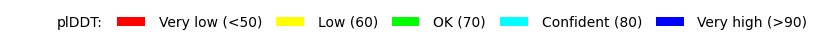

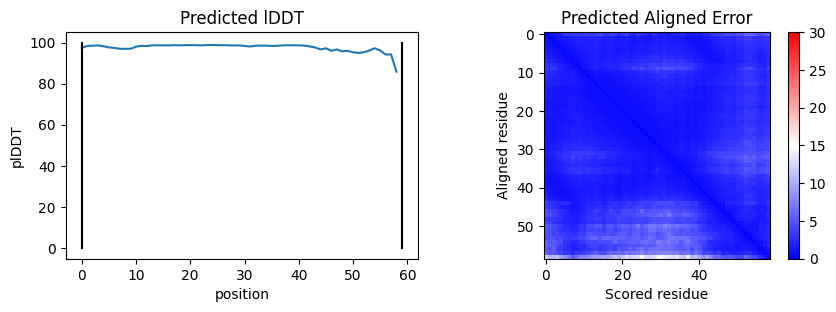

In [7]:
#@title Display 3D structure {run: "auto"}
model_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

def plot_plddt_legend():
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=100)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt

def plot_confidence(model_num=1):
  model_name = f"model_{model_num}"
  plt.figure(figsize=(10,3),dpi=100)
  """Plots the legend for plDDT."""
  #########################################
  plt.subplot(1,2,1); plt.title('Predicted lDDT')
  plt.plot(outs[model_name]["plddt"])
  for n in range(homooligomer+1):
    x = n*(len(query_sequence))
    plt.plot([x,x],[0,100],color="black")
  plt.ylabel('plDDT')
  plt.xlabel('position')
  #########################################
  plt.subplot(1,2,2);plt.title('Predicted Aligned Error')
  plt.imshow(outs[model_name]["pae"], cmap="bwr",vmin=0,vmax=30)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')
  #########################################
  return plt

def show_pdb(model_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"model_{model_num}"
  if use_amber:
    pdb_filename = f"{jobname}_relaxed_{model_name}.pdb"
  else:
    pdb_filename = f"{jobname}_unrelaxed_{model_name}.pdb"

  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_filename,'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(homooligomer),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(model_num,show_sidechains, show_mainchains, color).show()
if color == "lDDT": plot_plddt_legend().show()  
plot_confidence(model_num).show()

In [8]:
#@title Package and download results
#@markdown If you having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

citations = {
  "Ovchinnikov2021":  """@software{Ovchinnikov2021,
author = {Ovchinnikov, Sergey and Steinegger, Martin and Mirdita, Milot},
title = {{ColabFold - Making Protein folding accessible to all via Google Colab}},
year = {2021},
publisher = {Zenodo},
version = {v1.0-alpha},
doi = {10.5281/zenodo.5123297},
url = {https://doi.org/10.5281/zenodo.5123297},
comment = {The AlphaFold notebook}
}""",
  "LevyKarin2020": """@article{LevyKarin2020,
author = {{Levy Karin}, Eli and Mirdita, Milot and S{\"{o}}ding, Johannes},
doi = {10.1186/s40168-020-00808-x},
journal = {Microbiome},
number = {1},
title = {{MetaEuk—sensitive, high-throughput gene discovery, and annotation for large-scale eukaryotic metagenomics}},
volume = {8},
year = {2020},
comment = {MetaEuk database}
}""",
  "Delmont2020": """@article{Delmont2020,
author = {Delmont, Tom O. and Gaia, Morgan and Hinsinger, Damien D. and Fremont, Paul and Guerra, Antonio Fernandez and Eren, A. Murat and Vanni, Chiara and Kourlaiev, Artem and D'Agata, Leo and Clayssen, Quentin and Villar, Emilie and Labadie, Karine and Cruaud, Corinne and Poulain, Julie and da Silva, Corinne and Wessner, Marc and Noel, Benjamin and Aury, Jean Marc and de Vargas, Colomban and Bowler, Chris and Karsenti, Eric and Pelletier, Eric and Wincker, Patrick and Jaillon, Olivier and Sunagawa, Shinichi and Acinas, Silvia G. and Bork, Peer and Karsenti, Eric and Bowler, Chris and Sardet, Christian and Stemmann, Lars and de Vargas, Colomban and Wincker, Patrick and Lescot, Magali and Babin, Marcel and Gorsky, Gabriel and Grimsley, Nigel and Guidi, Lionel and Hingamp, Pascal and Jaillon, Olivier and Kandels, Stefanie and Iudicone, Daniele and Ogata, Hiroyuki and Pesant, St{\'{e}}phane and Sullivan, Matthew B. and Not, Fabrice and Karp-Boss, Lee and Boss, Emmanuel and Cochrane, Guy and Follows, Michael and Poulton, Nicole and Raes, Jeroen and Sieracki, Mike and Speich, Sabrina},
journal = {bioRxiv},
title = {{Functional repertoire convergence of distantly related eukaryotic plankton lineages revealed by genome-resolved metagenomics}},
year = {2020},
comment = {SMAG database}
}""",
  "Mitchell2019": """@article{Mitchell2019,
author = {Mitchell, Alex L and Almeida, Alexandre and Beracochea, Martin and Boland, Miguel and Burgin, Josephine and Cochrane, Guy and Crusoe, Michael R and Kale, Varsha and Potter, Simon C and Richardson, Lorna J and Sakharova, Ekaterina and Scheremetjew, Maxim and Korobeynikov, Anton and Shlemov, Alex and Kunyavskaya, Olga and Lapidus, Alla and Finn, Robert D},
doi = {10.1093/nar/gkz1035},
journal = {Nucleic Acids Res.},
title = {{MGnify: the microbiome analysis resource in 2020}},
year = {2019},
comment = {MGnify database}
}""",
  "Eastman2017": """@article{Eastman2017,
author = {Eastman, Peter and Swails, Jason and Chodera, John D. and McGibbon, Robert T. and Zhao, Yutong and Beauchamp, Kyle A. and Wang, Lee-Ping and Simmonett, Andrew C. and Harrigan, Matthew P. and Stern, Chaya D. and Wiewiora, Rafal P. and Brooks, Bernard R. and Pande, Vijay S.},
doi = {10.1371/journal.pcbi.1005659},
journal = {PLOS Comput. Biol.},
number = {7},
title = {{OpenMM 7: Rapid development of high performance algorithms for molecular dynamics}},
volume = {13},
year = {2017},
comment = {Amber relaxation}
}""",
  "Jumper2021": """@article{Jumper2021,
author = {Jumper, John and Evans, Richard and Pritzel, Alexander and Green, Tim and Figurnov, Michael and Ronneberger, Olaf and Tunyasuvunakool, Kathryn and Bates, Russ and {\v{Z}}{\'{i}}dek, Augustin and Potapenko, Anna and Bridgland, Alex and Meyer, Clemens and Kohl, Simon A. A. and Ballard, Andrew J. and Cowie, Andrew and Romera-Paredes, Bernardino and Nikolov, Stanislav and Jain, Rishub and Adler, Jonas and Back, Trevor and Petersen, Stig and Reiman, David and Clancy, Ellen and Zielinski, Michal and Steinegger, Martin and Pacholska, Michalina and Berghammer, Tamas and Bodenstein, Sebastian and Silver, David and Vinyals, Oriol and Senior, Andrew W. and Kavukcuoglu, Koray and Kohli, Pushmeet and Hassabis, Demis},
doi = {10.1038/s41586-021-03819-2},
journal = {Nature},
pmid = {34265844},
title = {{Highly accurate protein structure prediction with AlphaFold.}},
year = {2021},
comment = {AlphaFold2 + BFD Database}
}""",
  "Mirdita2019": """@article{Mirdita2019,
author = {Mirdita, Milot and Steinegger, Martin and S{\"{o}}ding, Johannes},
doi = {10.1093/bioinformatics/bty1057},
journal = {Bioinformatics},
number = {16},
pages = {2856--2858},
pmid = {30615063},
title = {{MMseqs2 desktop and local web server app for fast, interactive sequence searches}},
volume = {35},
year = {2019},
comment = {MMseqs2 search server}
}""",
  "Steinegger2019": """@article{Steinegger2019,
author = {Steinegger, Martin and Meier, Markus and Mirdita, Milot and V{\"{o}}hringer, Harald and Haunsberger, Stephan J. and S{\"{o}}ding, Johannes},
doi = {10.1186/s12859-019-3019-7},
journal = {BMC Bioinform.},
number = {1},
pages = {473},
pmid = {31521110},
title = {{HH-suite3 for fast remote homology detection and deep protein annotation}},
volume = {20},
year = {2019},
comment = {PDB70 database}
}""",
  "Mirdita2017": """@article{Mirdita2017,
author = {Mirdita, Milot and von den Driesch, Lars and Galiez, Clovis and Martin, Maria J. and S{\"{o}}ding, Johannes and Steinegger, Martin},
doi = {10.1093/nar/gkw1081},
journal = {Nucleic Acids Res.},
number = {D1},
pages = {D170--D176},
pmid = {27899574},
title = {{Uniclust databases of clustered and deeply annotated protein sequences and alignments}},
volume = {45},
year = {2017},
comment = {Uniclust30/UniRef30 database},
}""",
  "Berman2003": """@misc{Berman2003,
author = {Berman, Helen and Henrick, Kim and Nakamura, Haruki},
booktitle = {Nat. Struct. Biol.},
doi = {10.1038/nsb1203-980},
number = {12},
pages = {980},
pmid = {14634627},
title = {{Announcing the worldwide Protein Data Bank}},
volume = {10},
year = {2003},
comment = {templates downloaded from wwPDB server}
}""",
}

to_cite = [ "Jumper2021", "Ovchinnikov2021" ]
if use_msa:       to_cite += ["Mirdita2019"]
if use_msa:       to_cite += ["Mirdita2017"]
if use_env:       to_cite += ["Mitchell2019"]
if use_env:       to_cite += ["Delmont2020"]
if use_env:       to_cite += ["LevyKarin2020"]
if use_templates: to_cite += ["Steinegger2019"]
if use_templates: to_cite += ["Berman2003"]
if use_amber:     to_cite += ["Eastman2017"]

with open(f"{jobname}.bibtex", 'w') as writer:
  for i in to_cite:
    writer.write(citations[i])
    writer.write("\n")

print(f"Found {len(to_cite)} citation{'s' if len(to_cite) > 1 else ''} for tools or databases.")
if use_custom_msa:
  print("Don't forget to cite your custom MSA generation method.")

!zip -FSr $jobname".result.zip" $jobname".log" $a3m_file $jobname"_"*"relaxed_model_"*".pdb" $jobname"_coverage_lDDT.png" $jobname".bibtex" $jobname"_PAE.png"
files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive != None:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

Found 7 citations for tools or databases.
  adding: test_a5e17.log (deflated 14%)
  adding: test_a5e17.a3m (deflated 62%)
  adding: test_a5e17_unrelaxed_model_1.pdb (deflated 78%)
  adding: test_a5e17_unrelaxed_model_2.pdb (deflated 77%)
  adding: test_a5e17_unrelaxed_model_3.pdb (deflated 78%)
  adding: test_a5e17_unrelaxed_model_4.pdb (deflated 78%)
  adding: test_a5e17_unrelaxed_model_5.pdb (deflated 77%)
  adding: test_a5e17_coverage_lDDT.png (deflated 7%)
  adding: test_a5e17.bibtex (deflated 54%)
  adding: test_a5e17_PAE.png (deflated 2%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Instructions <a name="Instructions"></a>
**Quick start**
1. Change the runtime type to GPU at "Runtime" -> "Change runtime type" (improves speed).
2. Paste your protein sequence in the input field below.
3. Press "Runtime" -> "Run all".
4. The pipeline consists of 10 steps. The currently running steps is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pIDDT. (relaxed, unrelaxed).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the msa_mode: to "custom", (2) Wait for an upload box to appear at the end of the "Input Protein ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

To generate good input MSAs the HHblits server can be used here: https://toolkit.tuebingen.mpg.de/tools/hhblits

After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the a3m file and upload it to the notebook.

**Troubleshooting**
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Colab assigns different types of GPUs with varying amount of memory. Some might have not enough memory to predict the structure.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or Mgnify.
* Computing resources: Our MMseqs2 API can probably handle ~20k requests per day.
* For best results, we recommend using the full pipeline: https://github.com/deepmind/alphafold

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. Higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. Lower the better.



**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues


**Acknowledgments**
- We would like to thank the AlphaFold team for developing an excellent model and open sourcing the software. 

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).

- Minkyung Baek ([@minkbaek](https://twitter.com/minkbaek)) and Yoshitaka Moriwaki ([@Ag_smith](https://twitter.com/Ag_smith)) for protein-complex prediction proof-of-concept in AlphaFold2.

- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- For related notebooks see: [ColabFold](https://github.com/sokrypton/ColabFold)


## Generate Protein Content Maps

In [9]:
!sudo apt-get install python-numpy python-biopython python-matplotlib python-docopt dssp python2.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-numpy is already the newest version (1:1.13.3-2ubuntu1).
python-numpy set to manually installed.
python2.7 is already the newest version (2.7.17-1~18.04ubuntu1.6).
python2.7 set to manually installed.
The following additional packages will be installed:
  fonts-lyx gsfonts javascript-common libart-2.0-2 libjs-jquery
  libjs-jquery-ui ncbi-blast+ ncbi-data python-backports.functools-lru-cache
  python-biopython-doc python-cycler python-dateutil python-matplotlib-data
  python-olefile python-pil python-pyparsing python-renderpm python-reportlab
  python-reportlab-accel python-six python-subprocess32 python-tz
  ttf-bitstream-vera
Suggested packages:
  apache2 | lighttpd | httpd libjs-jquery-ui-docs bwa clustalo clustalw
  dialign emboss fasttree mafft muscle phylip phyml prank probcons
  python-mysqldb python-rdflib python-psycopg2 python-scipy raxml samtools
  t-coffee wise w3-dtd-math

In [10]:
!git clone https://github.com/kianho/pconpy.git

Cloning into 'pconpy'...
remote: Enumerating objects: 384, done.
remote: Total 384 (delta 0), reused 0 (delta 0), pack-reused 384
Receiving objects: 100% (384/384), 1.30 MiB | 3.26 MiB/s, done.
Resolving deltas: 100% (220/220), done.


In [11]:
!ls

AF2_READY     test_a5e17.a3m		    test_a5e17_PAE.png
alphafold     test_a5e17.bibtex		    test_a5e17.result.zip
alphafold_    test_a5e17_coverage_lDDT.png  test_a5e17_unrelaxed_model_1.pdb
MMSEQ2_READY  test_a5e17.fasta		    test_a5e17_unrelaxed_model_2.pdb
params	      test_a5e17.log		    test_a5e17_unrelaxed_model_3.pdb
pconpy	      test_a5e17.m8		    test_a5e17_unrelaxed_model_4.pdb
sample_data   test_a5e17.mmseqs2.tar.gz     test_a5e17_unrelaxed_model_5.pdb


In [12]:
!pwd

/content


### Visualize Content Maps

In [13]:
!python2.7 ./pconpy/pconpy/pconpy.py cmap 8.0 --pdb ./test_a5e17_unrelaxed_model_1.pdb \
          --chains A --output test_a5e17_unrelaxed_model_1_cmap.pdf --measure CA 

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Using hosted static image as Colab has trouble displaying pdf files

In [14]:
from IPython.display import Image
Image(url="https://github.com/aminoscape/alphafold2-cmaps/blob/main/img/test_a5e17_unrelaxed_model_1_cmap.jpg?raw=true")

In [15]:
!python2.7 ./pconpy/pconpy/pconpy.py dmap --pdb ./test_a5e17_unrelaxed_model_1.pdb \
          --chains A --output test_a5e17_unrelaxed_model_1_cmap.png --measure minvdw

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


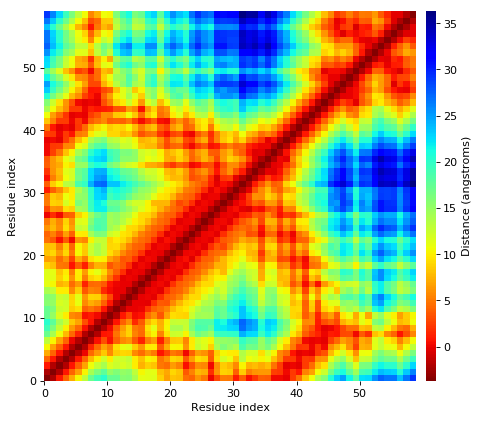

In [16]:
from IPython.display import Image
Image('/content/test_a5e17_unrelaxed_model_1_cmap.png')

### Generate as matrices

In [18]:
import numpy as np

In [24]:
!python2.7 ./pconpy/pconpy/pconpy.py cmap 8.0 --pdb ./test_a5e17_unrelaxed_model_1.pdb \
          --chains A --plaintext --output test_a5e17_unrelaxed_model_1_cmap.txt --measure CA 

In [28]:
cmap_matrix = np.genfromtxt('test_a5e17_unrelaxed_model_1_cmap.txt')

In [26]:
!python2.7 ./pconpy/pconpy/pconpy.py dmap --pdb ./test_a5e17_unrelaxed_model_1.pdb \
          --chains A --plaintext --output test_a5e17_unrelaxed_model_1_dmap.txt --measure CA 

In [29]:
dmap_matrix = np.genfromtxt('test_a5e17_unrelaxed_model_1_dmap.txt')

In [27]:
!python2.7 ./pconpy/pconpy/pconpy.py hbmap --pdb ./test_a5e17_unrelaxed_model_1.pdb \
          --chains A --plaintext --output test_a5e17_unrelaxed_model_1_hbmap.txt

In [32]:
hbmap_matrix = np.genfromtxt('test_a5e17_unrelaxed_model_1_hbmap.txt')

In [33]:
print(f'Contact Map matrix has shape: {cmap_matrix.shape}')
print(f'Distance Map matrix has shape: {dmap_matrix.shape}')
print(f'Hydrogen Bond Map matrix has shape: {hbmap_matrix.shape}')

Contact Map matrix has shape: (59, 59)
Distance Map matrix has shape: (59, 59)
Hydrogen Bond Map matrix has shape: (59, 59)
